# LowCarb thorax disease classification in Flower

## Check GPU availability

In [27]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct 21 14:48:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   27C    P0    49W / 400W |      3MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Create dirs, get data 

In [2]:
!mkdir NIH
!mkdir /root/.kaggle/

### Copy Kaggle API-key to created directory at '/root/.kaggle'

In [3]:
!cp '/content/drive/MyDrive/professional/Research_Jobs/UMI/projects/APIs/kaggle.json' '/root/.kaggle'

In [4]:
!kaggle datasets download -d nih-chest-xrays/data

100% 42.0G/42.0G [03:29<00:00, 195MB/s]
100% 42.0G/42.0G [03:29<00:00, 215MB/s]


In [5]:
!unzip -q '/content/data.zip' -d '/content/NIH/'

## Install packages

In [6]:
!pip install flwr[simulation]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 4.0 MB/s 
     |████████████████████████████████| 1.0 MB 30.0 MB/s 
     |████████████████████████████████| 54.5 MB 91 kB/s 
     |████████████████████████████████| 8.8 MB 54.5 MB/s 
     |████████████████████████████████| 4.1 MB 61.4 MB/s 
     |████████████████████████████████| 128 kB 77.1 MB/s 
     |████████████████████████████████| 3.0 MB 70.1 MB/s 
     |████████████████████████████████| 57 kB 5.8 MB/s 
     |████████████████████████████████| 201 kB 78.1 MB/s 
     |████████████████████████████████| 90 kB 11.2 MB/s 
     |████████████████████████████████| 291 kB 78.3 MB/s 
     |████████████████████████████████| 58 kB 6.9 MB/s 
     |████████████████████████████████| 468 kB 78.8 MB/s 
  Created wheel for gpustat: filename=gpustat-1.0.0-py3-none-any.whl size=19889 sha256=3dada07c3595668c8c2f1348669a6697c25d26dd0d65c4dff661d045f1696fbf
  S

## Imports

In [7]:
import os
import sys
import math
import time
from glob import glob
from PIL import Image
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nnqunt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torchvision import transforms as T, models

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on {DEVICE}")

Training on cuda:0


## Data

### Preprocess

In [8]:
root_img_dir = '/content/NIH/'

In [9]:
all_xray_df = pd.read_csv(
    os.path.join(
        root_img_dir,
        'Data_Entry_2017.csv'
        )
    )

all_image_paths = {
    os.path.basename(x): x for x in 
    glob(os.path.join(root_img_dir, 'images*', '*', '*.png'))
    }

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))

all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
27375,00007125_001.png,No Finding,1,7125,62,F,AP,2500,2048,0.171,0.171,NaN,/content/NIH/images_004/images/00007125_001.png
23117,00006109_001.png,No Finding,1,6109,79,M,PA,2500,2048,0.171,0.171,NaN,/content/NIH/images_003/images/00006109_001.png
10993,00002856_009.png,Atelectasis|Effusion,9,2856,48,F,AP,2500,2048,0.168,0.168,NaN,/content/NIH/images_002/images/00002856_009.png


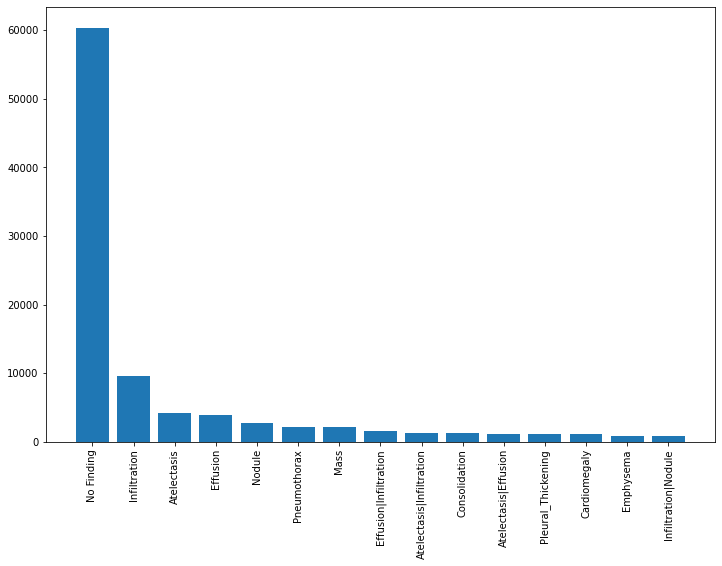

In [10]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [11]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
110908,00030247_006.png,,6,30247,54,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28573,00007451_014.png,,14,7451,66,M,PA,2992,2825,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35581,00009368_021.png,,21,9368,84,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [
    c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES
    ]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


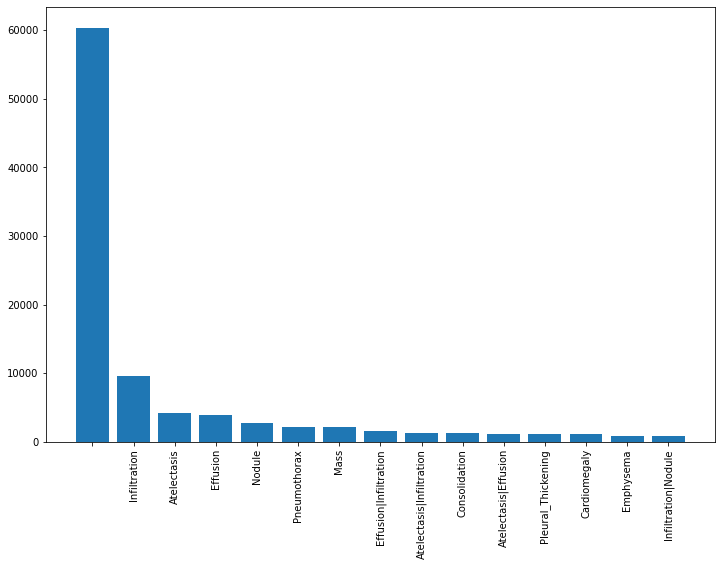

In [13]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()

all_xray_df = all_xray_df.sample(112120, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

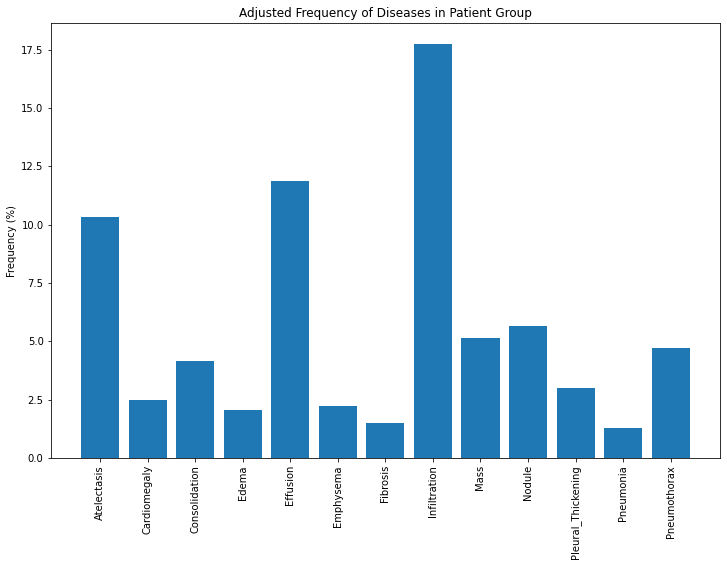

In [14]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [15]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [16]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,disease_vec
23932,00006304_016.png,Consolidation,16,6304,67,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16966,00004547_006.png,,6,4547,55,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22747,00006011_001.png,Fibrosis|Infiltration,1,6011,51,M,PA,3056,2544,0.139,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."


In [17]:
len(all_xray_df)

112120

### Get DataLoaders

In [18]:
class NIH_Dataset(Dataset):
  def __init__(
    self, 
    data_df,
    transform=None
    ):
    self.data_df = data_df
    self.transform = transform 

  def __len__(
    self
    ):
    return len(self.data_df)

  def __getitem__(
    self, 
    idx
    ):
    img_file = self.data_df['path'].iloc[idx]
    img = Image.open(img_file).convert('RGB')
    label = np.array(self.data_df.iloc[:,-1].iloc[idx], dtype=float)
    if self.transform:
        img = self.transform(img)

    return img, label

def get_data_loaders(
    data_df: pd.DataFrame,
    global_train_frac: float = 0.8,
    local_train_frac: float = 0.8,
    batch_size: int = 32,
    num_clients: int = 10
    ):
  train_data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    # T.Resize((512,512)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])

  test_data_transform = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
                ])
  
  train_df, test_df = train_test_split(
      data_df,
      test_size = 1 - global_train_frac,
      random_state = 42,
      stratify = data_df['Finding Labels'].map( lambda x: x[:4])
  )

  trainset = NIH_Dataset(
      train_df,
      transform = train_data_transform
      )
  
  testset = NIH_Dataset(
      test_df,
      transform = test_data_transform
      )

  # Split training set into `num_clients` partitions to simulate different local datasets
  partition_size = len(trainset) // num_clients
  lengths = [partition_size] * num_clients
  lengths[-1] += len(trainset) - np.sum(lengths)
  datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

  # Split each partition into train/val and create DataLoader
  trainloaders = []
  valloaders = []
  for ds in datasets:      
      len_train = math.ceil(len(ds) * local_train_frac)
      len_val = len(ds) - math.ceil(len(ds) * local_train_frac)
      lengths = [len_train, len_val]
      ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
      trainloaders.append(DataLoader(ds_train, batch_size=batch_size, shuffle=True, drop_last = True))
      valloaders.append(DataLoader(ds_val, batch_size=batch_size, drop_last = True))
  testloader = DataLoader(testset, batch_size=batch_size)

  return trainloaders, valloaders, testloader

def inv_data_transform(img):
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img

In [19]:
num_clients = 14

trainloaders, valloaders, testloader = get_data_loaders(
    all_xray_df,
    global_train_frac = 0.95,
    local_train_frac = 0.9,
    num_clients = num_clients,
    batch_size = 25
)

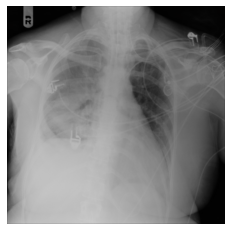

In [20]:
plt.imshow(
    inv_data_transform(
        testloader.dataset[0][0]
    )
)
plt.axis('off');

In [21]:
len(trainloaders[0].dataset), len(valloaders[0].dataset) ,len(testloader.dataset)

(6848, 760, 5607)

In [22]:
len(all_labels)

13

### Basic FL utils

In [23]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.cid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=local_epochs)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

### FL training utils

In [24]:
def compute_class_freqs(labels):

    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon = 1e-7):
    y_pred = torch.sigmoid(y_pred)
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def train(
    net,
    trainloader,
    epochs
    ):
    print(f'Entered train function, total num. of epochs: {epochs}')
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    valid_loss_min = np.Inf
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr = 1e-4
        )
    start_time = time.time()
    for i in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 
        net.train()
        for j, (images, labels) in enumerate(trainloader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            ps = net(images)
            
            loss = weighted_loss(pos_weights, neg_weights, ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)
        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
    end_time = time.time()
    time_delta = end_time - start_time
    print('\n')
    print(f'Time to complete local training round: {time_delta}')
    print('\n')

def test(net, testloader, pathology_list):
    
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            loss += weighted_loss( pos_weights, neg_weights, ps, labels)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset)) * 100.0 for i in per_class_accuracy]

    return loss, np.mean(per_class_accuracy)

def get_acc_data(
    class_names,
    acc_list
    ):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Class Acc.']) 
    return df

In [25]:
def server_eval(
    server_round: int,
    parameters: fl.common.NDArrays, 
    config: Dict[str, fl.common.Scalar]
    ):
    # ToDo: Class weights should be different for each client
    freq_pos, freq_neg = compute_class_freqs(all_xray_df.iloc[:,-1])    
    pos_weights = freq_neg
    neg_weights = freq_pos

    net = init_net().to(DEVICE)

    set_parameters(net, parameters)  # Update model with the latest parameters

    per_class_accuracy = [0 for i in range(len(all_labels))]
    total = 0.0
    loss = 0.0
    with torch.no_grad():
        for images,labels in testloader:
          
            ps = net(images.to(DEVICE))
            labels = labels.to(DEVICE)
            ps = (ps >= 0.5).float()

            loss += weighted_loss( pos_weights, neg_weights, ps, labels)

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(testloader.dataset))*100.0 for i in per_class_accuracy]

    test_df = get_acc_data(all_labels, per_class_accuracy)
    print('\nServer eval')
    print(test_df)
    print('\n')

    return loss,  {"mean_class_acc.": np.mean(per_class_accuracy)}

## Training

In [26]:
def init_net():
  net = models.vgg11(
    weights="IMAGENET1K_V1"
  )
  net.classifier[-1] = torch.nn.Linear(
      net.classifier[-1].in_features,
      len(all_labels)
  )
  return net

def client_fn(cid) -> FlowerClient:
    net = init_net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    print(f'Created client: {cid}')
    return FlowerClient(cid, net, trainloader, valloader)

### 4 local epochs take approx 15min. on A100 for each client

In [ ]:
num_rounds = 10
local_epochs = 4
fraction_fit = 0.05
fraction_evaluate = 0.05
min_fit_clients = 5
min_evaluate_clients = 5

client_resources = {
    "num_cpus": 1,
    "num_gpus": 1
    }

def fit_config(server_round: int):    
    config = {
        "server_round": server_round,
        "local_epochs": local_epochs,
    }
    return config

# Create an instance of the model and get the parameters
net = init_net()
params = get_parameters(init_net())

# Pass parameters to the Strategy for server-side parameter initialization
strategy = fl.server.strategy.FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=num_clients,
    initial_parameters=fl.common.ndarrays_to_parameters(params),
    evaluate_fn=server_eval,
    on_fit_config_fn=fit_config,
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=num_clients,
    client_resources=client_resources,
    config=fl.server.ServerConfig(num_rounds=num_rounds),
    strategy=strategy,
)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

INFO flower 2022-10-21 14:48:56,060 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flower:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO flower 2022-10-21 14:48:59,087 | app.py:179 | Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.28.0.2': 1.0, 'GPU': 1.0, 'memory': 53563509966.0, 'object_store_memory': 26781754982.0}
INFO:flower:Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'node:172.28.0.2': 1.0, 'GPU': 1.0, 'memory': 53563509966.0, 'object_store_memory': 26781754982.0}
INFO flower 2022-10-21 14:48:59,090 | server.py:86 | Initializing global parameters
INFO:flower:Initializing global parameters
INFO flower 2022-10-21 14:48:59,093 | server.py:266 | Using initial parameters provided by strategy
INFO:flower:Using initial parameters provided by strategy
INFO flower 2022-10-21 14:48:59,096 | server.py:88 | Evaluating initial parameters
INFO:flower:Evaluating i


Server eval
                Labels  Class Acc.
0          Atelectasis   81.398252
1         Cardiomegaly   97.413947
2        Consolidation   65.346888
3                Edema   94.471197
4             Effusion   88.228999
5            Emphysema   96.308186
6             Fibrosis   51.293027
7         Infiltration   77.010879
8                 Mass   94.453362
9               Nodule   93.276262
10  Pleural_Thickening   85.357589
11           Pneumonia   65.275548
12        Pneumothorax   94.043160


(launch_and_fit pid=1115) Created client: 1
(launch_and_fit pid=1115) [Client 1, round 1] fit, config: {'server_round': 1, 'local_epochs': 4}
(launch_and_fit pid=1115) Entered train function, total num. of epochs: 4
(launch_and_fit pid=1115) Epoch : 1 Train Loss : 0.888080 
(launch_and_fit pid=1115) Epoch : 2 Train Loss : 0.835466 
(launch_and_fit pid=1115) Epoch : 3 Train Loss : 0.799197 
(launch_and_fit pid=1115) Epoch : 4 Train Loss : 0.780529 
(launch_and_fit pid=1115) 
(launch_and_fit 

DEBUG flower 2022-10-21 16:03:31,847 | server.py:234 | fit_round 1 received 5 results and 0 failures
DEBUG:flower:fit_round 1 received 5 results and 0 failures
WARNING flower 2022-10-21 16:03:40,399 | fedavg.py:243 | No fit_metrics_aggregation_fn provided
INFO flower 2022-10-21 16:06:38,608 | server.py:122 | fit progress: (1, tensor(203.2069, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.46570907245064}, 4466.866817333001)
INFO:flower:fit progress: (1, tensor(203.2069, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 94.46570907245064}, 4466.866817333001)
DEBUG flower 2022-10-21 16:06:38,618 | server.py:170 | evaluate_round 1: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 1: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.709292
1         Cardiomegaly   97.556626
2        Consolidation   95.951489
3                Edema   98.002497
4             Effusion   88.246834
5            Emphysema   97.538791
6             Fibrosis   98.466203
7         Infiltration   82.272160
8                 Mass   95.184591
9               Nodule   94.453362
10  Pleural_Thickening   96.682718
11           Pneumonia   98.698056
12        Pneumothorax   95.291600




DEBUG flower 2022-10-21 16:07:09,808 | server.py:184 | evaluate_round 1 received 0 results and 5 failures
DEBUG:flower:evaluate_round 1 received 0 results and 5 failures
DEBUG flower 2022-10-21 16:07:09,811 | server.py:220 | fit_round 2: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 2: strategy sampled 5 clients (out of 14)


(launch_and_fit pid=3020) Created client: 10
(launch_and_fit pid=3020) [Client 10, round 2] fit, config: {'server_round': 2, 'local_epochs': 4}
(launch_and_fit pid=3020) Entered train function, total num. of epochs: 4
(launch_and_fit pid=3020) Epoch : 1 Train Loss : 0.835185 
(launch_and_fit pid=3020) Epoch : 2 Train Loss : 0.798971 
(launch_and_fit pid=3020) Epoch : 3 Train Loss : 0.786819 
(launch_and_fit pid=3020) Epoch : 4 Train Loss : 0.766328 
(launch_and_fit pid=3020) 
(launch_and_fit pid=3020) 
(launch_and_fit pid=3020) Time to complete local training round: 850.7281773090363
(launch_and_fit pid=3020) 
(launch_and_fit pid=3020) 
(launch_and_fit pid=3274) Created client: 5
(launch_and_fit pid=3274) [Client 5, round 2] fit, config: {'server_round': 2, 'local_epochs': 4}
(launch_and_fit pid=3274) Entered train function, total num. of epochs: 4
(launch_and_fit pid=3274) Epoch : 1 Train Loss : 0.810188 
(launch_and_fit pid=3274) Epoch : 2 Train Loss : 0.778977 
(launch_and_fit pid=3

DEBUG flower 2022-10-21 16:50:17,649 | server.py:234 | fit_round 2 received 3 results and 2 failures
DEBUG:flower:fit_round 2 received 3 results and 2 failures
INFO flower 2022-10-21 16:53:19,948 | server.py:122 | fit progress: (2, tensor(197.2564, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 87.9889149552071}, 7268.206241316999)
INFO:flower:fit progress: (2, tensor(197.2564, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 87.9889149552071}, 7268.206241316999)
DEBUG flower 2022-10-21 16:53:19,955 | server.py:170 | evaluate_round 2: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 2: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.548778
1         Cardiomegaly   97.003745
2        Consolidation   81.879793
3                Edema   64.758338
4             Effusion   86.302836
5            Emphysema   86.962725
6             Fibrosis   97.342607
7         Infiltration   80.167648
8                 Mass   91.831639
9               Nodule   94.043160
10  Pleural_Thickening   94.275013
11           Pneumonia   93.008739
12        Pneumothorax   86.730872


(launch_and_evaluate pid=3942) Created client: 12
(launch_and_evaluate pid=3942) [Client 12] evaluate, config: {}
(launch_and_evaluate pid=4002) Created client: 8
(launch_and_evaluate pid=4002) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=4037) Created client: 5
(launch_and_evaluate pid=4037) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=4072) Created client: 13
(launch_and_evaluate pid=4072) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=4108) Created clie

DEBUG flower 2022-10-21 16:54:02,113 | server.py:184 | evaluate_round 2 received 0 results and 5 failures
DEBUG:flower:evaluate_round 2 received 0 results and 5 failures
DEBUG flower 2022-10-21 16:54:02,118 | server.py:220 | fit_round 3: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 3: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=4108) [Client 6] evaluate, config: {}
(launch_and_fit pid=4196) Created client: 12
(launch_and_fit pid=4196) [Client 12, round 3] fit, config: {'server_round': 3, 'local_epochs': 4}
(launch_and_fit pid=4196) Entered train function, total num. of epochs: 4
(launch_and_fit pid=4196) Epoch : 1 Train Loss : 0.792904 
(launch_and_fit pid=4196) Epoch : 2 Train Loss : 0.766543 
(launch_and_fit pid=4196) Epoch : 3 Train Loss : 0.746725 
(launch_and_fit pid=4196) Epoch : 4 Train Loss : 0.730858 
(launch_and_fit pid=4196) 
(launch_and_fit pid=4196) 
(launch_and_fit pid=4196) Time to complete local training round: 772.0225481987
(launch_and_fit pid=4196) 
(launch_and_fit pid=4196) 
(launch_and_fit pid=4674) Created client: 8
(launch_and_fit pid=4674) [Client 8, round 3] fit, config: {'server_round': 3, 'local_epochs': 4}
(launch_and_fit pid=4674) Entered train function, total num. of epochs: 4
(launch_and_fit pid=4674) Epoch : 1 Train Loss : 0.779254 
(launch_and_fit pid=

DEBUG flower 2022-10-21 17:20:09,527 | server.py:234 | fit_round 3 received 2 results and 3 failures
DEBUG:flower:fit_round 3 received 2 results and 3 failures
INFO flower 2022-10-21 17:23:00,205 | server.py:122 | fit progress: (3, tensor(195.0225, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.37492968953643}, 9048.463768504)
INFO:flower:fit progress: (3, tensor(195.0225, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.37492968953643}, 9048.463768504)
DEBUG flower 2022-10-21 17:23:00,210 | server.py:170 | evaluate_round 3: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 3: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   87.907972
1         Cardiomegaly   93.222757
2        Consolidation   73.140717
3                Edema   62.243624
4             Effusion   81.737114
5            Emphysema   73.978955
6             Fibrosis   84.180489
7         Infiltration   80.345996
8                 Mass   85.714286
9               Nodule   90.868557
10  Pleural_Thickening   85.696451
11           Pneumonia   70.608168
12        Pneumothorax   88.228999


(launch_and_evaluate pid=5248) Created client: 5
(launch_and_evaluate pid=5248) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=5291) Created client: 6
(launch_and_evaluate pid=5291) [Client 6] evaluate, config: {}
(launch_and_evaluate pid=5329) Created client: 11
(launch_and_evaluate pid=5329) [Client 11] evaluate, config: {}
(scheduler +2h35m34s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(scheduler +2h35m34s) War

DEBUG flower 2022-10-21 17:23:40,455 | server.py:184 | evaluate_round 3 received 0 results and 5 failures
DEBUG:flower:evaluate_round 3 received 0 results and 5 failures
DEBUG flower 2022-10-21 17:23:40,458 | server.py:220 | fit_round 4: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 4: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=5401) [Client 2] evaluate, config: {}
(launch_and_fit pid=5469) Created client: 4
(launch_and_fit pid=5469) [Client 4, round 4] fit, config: {'server_round': 4, 'local_epochs': 4}
(launch_and_fit pid=5469) Entered train function, total num. of epochs: 4
(launch_and_fit pid=5469) Epoch : 1 Train Loss : 0.767781 
(launch_and_fit pid=5469) Epoch : 2 Train Loss : 0.738629 
(launch_and_fit pid=5469) Epoch : 3 Train Loss : 0.720147 
(launch_and_fit pid=5469) Epoch : 4 Train Loss : 0.698585 
(launch_and_fit pid=5469) 
(launch_and_fit pid=5469) 
(launch_and_fit pid=5469) Time to complete local training round: 753.5850644111633
(launch_and_fit pid=5469) 
(launch_and_fit pid=5469) 
(launch_and_fit pid=5842) Created client: 2
(launch_and_fit pid=5842) [Client 2, round 4] fit, config: {'server_round': 4, 'local_epochs': 4}
(launch_and_fit pid=5842) Entered train function, total num. of epochs: 4
(launch_and_fit pid=5842) Epoch : 1 Train Loss : 0.777039 
(launch_and_fit pid

DEBUG flower 2022-10-21 18:02:13,610 | server.py:234 | fit_round 4 received 3 results and 2 failures
DEBUG:flower:fit_round 4 received 3 results and 2 failures
INFO flower 2022-10-21 18:05:04,711 | server.py:122 | fit progress: (4, tensor(195.7310, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.77827166591211}, 11572.969144073999)
INFO:flower:fit progress: (4, tensor(195.7310, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 81.77827166591211}, 11572.969144073999)
DEBUG flower 2022-10-21 18:05:04,716 | server.py:170 | evaluate_round 4: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 4: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   88.246834
1         Cardiomegaly   96.629213
2        Consolidation   88.264669
3                Edema   86.552524
4             Effusion   86.445515
5            Emphysema   70.929196
6             Fibrosis   59.229535
7         Infiltration   81.719279
8                 Mass   74.406991
9               Nodule   86.606028
10  Pleural_Thickening   76.850366
11           Pneumonia   86.285001
12        Pneumothorax   80.952381


(launch_and_evaluate pid=6572) Created client: 9
(launch_and_evaluate pid=6572) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=6607) Created client: 8
(launch_and_evaluate pid=6607) [Client 8] evaluate, config: {}
(launch_and_evaluate pid=6642) Created client: 10
(launch_and_evaluate pid=6642) [Client 10] evaluate, config: {}
(launch_and_evaluate pid=6678) Created client: 7


DEBUG flower 2022-10-21 18:05:42,182 | server.py:184 | evaluate_round 4 received 0 results and 5 failures
DEBUG:flower:evaluate_round 4 received 0 results and 5 failures
DEBUG flower 2022-10-21 18:05:42,186 | server.py:220 | fit_round 5: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 5: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=6678) [Client 7] evaluate, config: {}
(launch_and_fit pid=6767) Created client: 9
(launch_and_fit pid=6767) [Client 9, round 5] fit, config: {'server_round': 5, 'local_epochs': 4}
(launch_and_fit pid=6767) Entered train function, total num. of epochs: 4
(launch_and_fit pid=6767) Epoch : 1 Train Loss : 0.761519 
(launch_and_fit pid=6767) Epoch : 2 Train Loss : 0.734977 
(launch_and_fit pid=6767) Epoch : 3 Train Loss : 0.717751 
(launch_and_fit pid=6767) Epoch : 4 Train Loss : 0.696333 
(launch_and_fit pid=6767) 
(launch_and_fit pid=6767) 
(launch_and_fit pid=6767) Time to complete local training round: 770.0740931034088
(launch_and_fit pid=6767) 
(launch_and_fit pid=6767) 
(launch_and_fit pid=7050) Created client: 6
(launch_and_fit pid=7050) [Client 6, round 5] fit, config: {'server_round': 5, 'local_epochs': 4}
(launch_and_fit pid=7050) Entered train function, total num. of epochs: 4
(launch_and_fit pid=7093) Created client: 7
(launch_and_fit pid=7093) [Client 

DEBUG flower 2022-10-21 18:57:51,717 | server.py:234 | fit_round 5 received 4 results and 1 failures
DEBUG:flower:fit_round 5 received 4 results and 1 failures
INFO flower 2022-10-21 19:00:49,968 | server.py:122 | fit progress: (5, tensor(195.9808, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 77.28114582047166}, 14918.226132992999)
INFO:flower:fit progress: (5, tensor(195.9808, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 77.28114582047166}, 14918.226132992999)
DEBUG flower 2022-10-21 19:00:49,973 | server.py:170 | evaluate_round 5: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 5: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   88.014981
1         Cardiomegaly   97.449617
2        Consolidation   81.826289
3                Edema   87.123239
4             Effusion   85.821295
5            Emphysema   64.330301
6             Fibrosis   55.930087
7         Infiltration   81.754949
8                 Mass   58.159444
9               Nodule   76.279650
10  Pleural_Thickening   67.540574
11           Pneumonia   81.826289
12        Pneumothorax   78.598181


(launch_and_evaluate pid=8005) Created client: 1
(launch_and_evaluate pid=8005) [Client 1] evaluate, config: {}
(launch_and_evaluate pid=8040) Created client: 9


DEBUG flower 2022-10-21 19:01:23,647 | server.py:184 | evaluate_round 5 received 0 results and 5 failures
DEBUG:flower:evaluate_round 5 received 0 results and 5 failures
DEBUG flower 2022-10-21 19:01:23,651 | server.py:220 | fit_round 6: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 6: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=8040) [Client 9] evaluate, config: {}
(launch_and_fit pid=8136) Created client: 6
(launch_and_fit pid=8136) [Client 6, round 6] fit, config: {'server_round': 6, 'local_epochs': 4}
(launch_and_fit pid=8136) Entered train function, total num. of epochs: 4
(scheduler +4h13m42s) Warning: The following resource request cannot be scheduled right now: {'GPU': 1.0, 'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.
(launch_and_fit pid=8238) Created client: 8
(launch_and_fit pid=8238) [Client 8, round 6] fit, config: {'server_round': 6, 'local_epochs': 4}
(launch_and_fit pid=8238) Entered train function, total num. of epochs: 4
(launch_and_fit pid=8275) Created client: 1
(launch_and_fit pid=8275) [Client 1, round 6] fit, config: {'server_round': 6, 'local_epochs': 4}
(launch_and_fit pid=8275) Entered train function, total num. of epochs: 4
(launch_and_fit pid=8275) Ep

DEBUG flower 2022-10-21 19:27:59,945 | server.py:234 | fit_round 6 received 2 results and 3 failures
DEBUG:flower:fit_round 6 received 2 results and 3 failures
INFO flower 2022-10-21 19:30:53,138 | server.py:122 | fit progress: (6, tensor(198.1630, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 83.64269937303646}, 16721.397061171003)
INFO:flower:fit progress: (6, tensor(198.1630, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 83.64269937303646}, 16721.397061171003)
DEBUG flower 2022-10-21 19:30:53,144 | server.py:170 | evaluate_round 6: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 6: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   85.232745
1         Cardiomegaly   97.485286
2        Consolidation   87.319422
3                Edema   94.150169
4             Effusion   88.175495
5            Emphysema   46.655966
6             Fibrosis   78.241484
7         Infiltration   82.325664
8                 Mass   91.421437
9               Nodule   94.025325
10  Pleural_Thickening   86.017478
11           Pneumonia   93.365436
12        Pneumothorax   62.939183


(launch_and_evaluate pid=8835) Created client: 2
(launch_and_evaluate pid=8835) [Client 2] evaluate, config: {}
(launch_and_evaluate pid=8943) Created client: 4
(launch_and_evaluate pid=8943) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=8978) Created client: 9
(launch_and_evaluate pid=8978) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=9013) Created client: 7
(launch_and_evaluate pid=9013) [Client 7] evaluate, config: {}
(launch_and_evaluate pid=9048) Created client: 

DEBUG flower 2022-10-21 19:31:33,747 | server.py:184 | evaluate_round 6 received 0 results and 5 failures
DEBUG:flower:evaluate_round 6 received 0 results and 5 failures
DEBUG flower 2022-10-21 19:31:33,751 | server.py:220 | fit_round 7: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 7: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=9048) [Client 5] evaluate, config: {}
(launch_and_fit pid=9198) Created client: 11
(launch_and_fit pid=9198) [Client 11, round 7] fit, config: {'server_round': 7, 'local_epochs': 4}
(launch_and_fit pid=9198) Entered train function, total num. of epochs: 4
(launch_and_fit pid=9198) Epoch : 1 Train Loss : 0.734423 
(launch_and_fit pid=9198) Epoch : 2 Train Loss : 0.709222 
(launch_and_fit pid=9198) Epoch : 3 Train Loss : 0.691675 
(launch_and_fit pid=9198) Epoch : 4 Train Loss : 0.663987 
(launch_and_fit pid=9198) 
(launch_and_fit pid=9198) 
(launch_and_fit pid=9198) Time to complete local training round: 786.9469661712646
(launch_and_fit pid=9198) 
(launch_and_fit pid=9198) 
(launch_and_fit pid=9430) Created client: 4
(launch_and_fit pid=9430) [Client 4, round 7] fit, config: {'server_round': 7, 'local_epochs': 4}
(launch_and_fit pid=9430) Entered train function, total num. of epochs: 4
(launch_and_fit pid=9466) Created client: 5
(launch_and_fit pid=9466) [Clien

DEBUG flower 2022-10-21 19:58:08,449 | server.py:234 | fit_round 7 received 2 results and 3 failures
DEBUG:flower:fit_round 7 received 2 results and 3 failures
INFO flower 2022-10-21 20:00:59,851 | server.py:122 | fit progress: (7, tensor(199.3988, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 84.32179555775063}, 18528.110082381)
INFO:flower:fit progress: (7, tensor(199.3988, device='cuda:0', dtype=torch.float64), {'mean_class_acc.': 84.32179555775063}, 18528.110082381)
DEBUG flower 2022-10-21 20:00:59,858 | server.py:170 | evaluate_round 7: strategy sampled 5 clients (out of 14)
DEBUG:flower:evaluate_round 7: strategy sampled 5 clients (out of 14)



Server eval
                Labels  Class Acc.
0          Atelectasis   89.513109
1         Cardiomegaly   97.538791
2        Consolidation   91.581951
3                Edema   92.848225
4             Effusion   88.318174
5            Emphysema   58.498306
6             Fibrosis   74.406991
7         Infiltration   81.380417
8                 Mass   91.938648
9               Nodule   87.890137
10  Pleural_Thickening   87.907972
11           Pneumonia   82.307829
12        Pneumothorax   72.052791


(launch_and_evaluate pid=9853) Created client: 5
(launch_and_evaluate pid=9853) [Client 5] evaluate, config: {}
(launch_and_evaluate pid=9948) Created client: 13
(launch_and_evaluate pid=9948) [Client 13] evaluate, config: {}
(launch_and_evaluate pid=9984) Created client: 9
(launch_and_evaluate pid=9984) [Client 9] evaluate, config: {}
(launch_and_evaluate pid=10019) Created client: 4
(launch_and_evaluate pid=10019) [Client 4] evaluate, config: {}
(launch_and_evaluate pid=10054) Created cli

DEBUG flower 2022-10-21 20:01:39,175 | server.py:184 | evaluate_round 7 received 0 results and 5 failures
DEBUG:flower:evaluate_round 7 received 0 results and 5 failures
DEBUG flower 2022-10-21 20:01:39,179 | server.py:220 | fit_round 8: strategy sampled 5 clients (out of 14)
DEBUG:flower:fit_round 8: strategy sampled 5 clients (out of 14)


(launch_and_evaluate pid=10054) [Client 6] evaluate, config: {}
(launch_and_fit pid=10162) Created client: 4
(launch_and_fit pid=10162) [Client 4, round 8] fit, config: {'server_round': 8, 'local_epochs': 4}
(launch_and_fit pid=10162) Entered train function, total num. of epochs: 4
(launch_and_fit pid=10162) Epoch : 1 Train Loss : 0.730587 
(launch_and_fit pid=10162) Epoch : 2 Train Loss : 0.707026 
(launch_and_fit pid=10162) Epoch : 3 Train Loss : 0.688020 
